In [1]:
pip install skrub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import folktables
from folktables import ACSDataSource, ACSEmployment, ACSIncome
from xgboost import XGBClassifier
from skrub import tabular_learner

import sklearn as sk
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,confusion_matrix,accuracy_score,balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform,randint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['TX'], download=True)

features_tx, label_tx, group_tx = ACSIncome.df_to_pandas(acs_data)
features_tx

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,21.0,3.0,16.0,5.0,3500.0,48.0,17.0,10.0,2.0,2.0
1,20.0,1.0,16.0,5.0,4720.0,39.0,17.0,50.0,2.0,1.0
2,31.0,1.0,17.0,5.0,4110.0,48.0,17.0,30.0,1.0,1.0
3,39.0,1.0,21.0,1.0,4255.0,18.0,16.0,40.0,1.0,1.0
4,18.0,1.0,16.0,5.0,4055.0,48.0,17.0,20.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...
135919,19.0,1.0,19.0,5.0,9620.0,48.0,2.0,40.0,1.0,1.0
135920,24.0,1.0,19.0,5.0,4760.0,48.0,10.0,40.0,1.0,1.0
135921,40.0,1.0,15.0,5.0,6260.0,48.0,12.0,40.0,1.0,1.0
135922,43.0,1.0,1.0,2.0,6330.0,17.0,0.0,48.0,1.0,1.0


In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['CA'], download=True)

features_ca, label_ca, group_ca = ACSIncome.df_to_pandas(acs_data)
features_ca

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
195660,38.0,1.0,22.0,1.0,1021.0,210.0,0.0,40.0,1.0,6.0
195661,39.0,1.0,22.0,1.0,1021.0,210.0,1.0,40.0,2.0,6.0
195662,61.0,1.0,19.0,1.0,5240.0,17.0,0.0,45.0,1.0,1.0
195663,69.0,7.0,24.0,1.0,2040.0,207.0,0.0,45.0,1.0,6.0


In [5]:
def hist_group_nb(state_1,state_2):
    features_1 = globals()[f"features_{str(state_1).lower()}"]
    features_2 = globals()[f"features_{str(state_2).lower()}"]

    liste_changement = ['AGEP','WKHP']

    # Figure : une grille de subplots
    n_cols = 2
    n_rows = int(np.ceil(float(features_1.shape[1]) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    # Fonction pour créer des intervalles
    def create_bins(series, bin_size=5):
        min_val = int(series.min() // bin_size * bin_size)
        max_val = int(np.ceil(series.max() / bin_size) * bin_size)
        return list(range(min_val, max_val + bin_size, bin_size))

    # Boucle sur les colonnes
    for idx, col in enumerate(features_1.columns):
        ax = axes[idx]

        if col in liste_changement:
            # Regroupement en classes pour cette colonne
            combined = pd.concat([features_1[col], features_2[col]])
            bins = create_bins(combined, bin_size=5)
            labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

            df1_binned = pd.cut(features_1[col], bins=bins, labels=labels, include_lowest=True)
            df2_binned = pd.cut(features_2[col], bins=bins, labels=labels, include_lowest=True)

            counts1 = df1_binned.value_counts().sort_index()
            counts2 = df2_binned.value_counts().sort_index()
            x_labels = labels
        else:
            # Utilisation des valeurs exactes
            counts1 = features_1[col].value_counts().sort_index()
            counts2 = features_2[col].value_counts().sort_index()
            x_labels = sorted(set(counts1.index).union(counts2.index))
            counts1 = counts1.reindex(x_labels, fill_value=0)
            counts2 = counts2.reindex(x_labels, fill_value=0)

        # Préparation des valeurs
        x = np.arange(len(x_labels))
        vals1 = counts1.values
        vals2 = counts2.values
        width = 0.4

        # Affichage des barres
        ax.bar(x - width/2, vals1, width=width, label=str(state_1).upper(), color='skyblue')
        ax.bar(x + width/2, vals2, width=width, label=str(state_2).upper(), color='salmon')

        ax.set_title(f'Distribution : {col}')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45)
        ax.set_ylabel('Occurrences')
        ax.legend()
        ax.grid(True, axis='y')

    # Supprimer les axes inutilisés
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def hist_group_prop(state_1,state_2):
    features_1 = globals()[f"features_{str(state_1).lower()}"]
    features_2 = globals()[f"features_{str(state_2).lower()}"]

    liste_changement = ['AGEP','WKHP']

    # Figure : une grille de subplots
    n_cols = 2
    n_rows = int(np.ceil(float(features_1.shape[1]) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    # Fonction pour créer des intervalles
    def create_bins(series, bin_size=5):
        min_val = int(series.min() // bin_size * bin_size)
        max_val = int(np.ceil(series.max() / bin_size) * bin_size)
        return list(range(min_val, max_val + bin_size, bin_size))

    # Boucle sur les colonnes
    for idx, col in enumerate(features_1.columns):
        ax = axes[idx]

        if col in liste_changement:
            # Regroupement en classes pour cette colonne
            combined = pd.concat([features_1[col], features_2[col]])
            bins = create_bins(combined, bin_size=5)
            labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

            df1_binned = pd.cut(features_1[col], bins=bins, labels=labels, include_lowest=True)
            df2_binned = pd.cut(features_2[col], bins=bins, labels=labels, include_lowest=True)

            counts1 = df1_binned.value_counts().sort_index()
            counts2 = df2_binned.value_counts().sort_index()
            x_labels = labels
        else:
            # Utilisation des valeurs exactes
            counts1 = features_1[col].value_counts().sort_index()
            counts2 = features_2[col].value_counts().sort_index()
            x_labels = sorted(set(counts1.index).union(counts2.index))
            counts1 = counts1.reindex(x_labels, fill_value=0)
            counts2 = counts2.reindex(x_labels, fill_value=0)

        # Préparation des valeurs
        x = np.arange(len(x_labels))
        vals1 = counts1.values/np.sum(counts1)
        vals2 = counts2.values/np.sum(counts2)
        width = 0.4

        # Affichage des barres
        ax.bar(x - width/2, vals1, width=width, label=str(state_1).upper(), color='skyblue')
        ax.bar(x + width/2, vals2, width=width, label=str(state_2).upper(), color='salmon')

        ax.set_title(f'Distribution : {col}')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45)
        ax.set_ylabel('Proportions')
        ax.legend()
        ax.grid(True, axis='y')

    # Supprimer les axes inutilisés
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
        

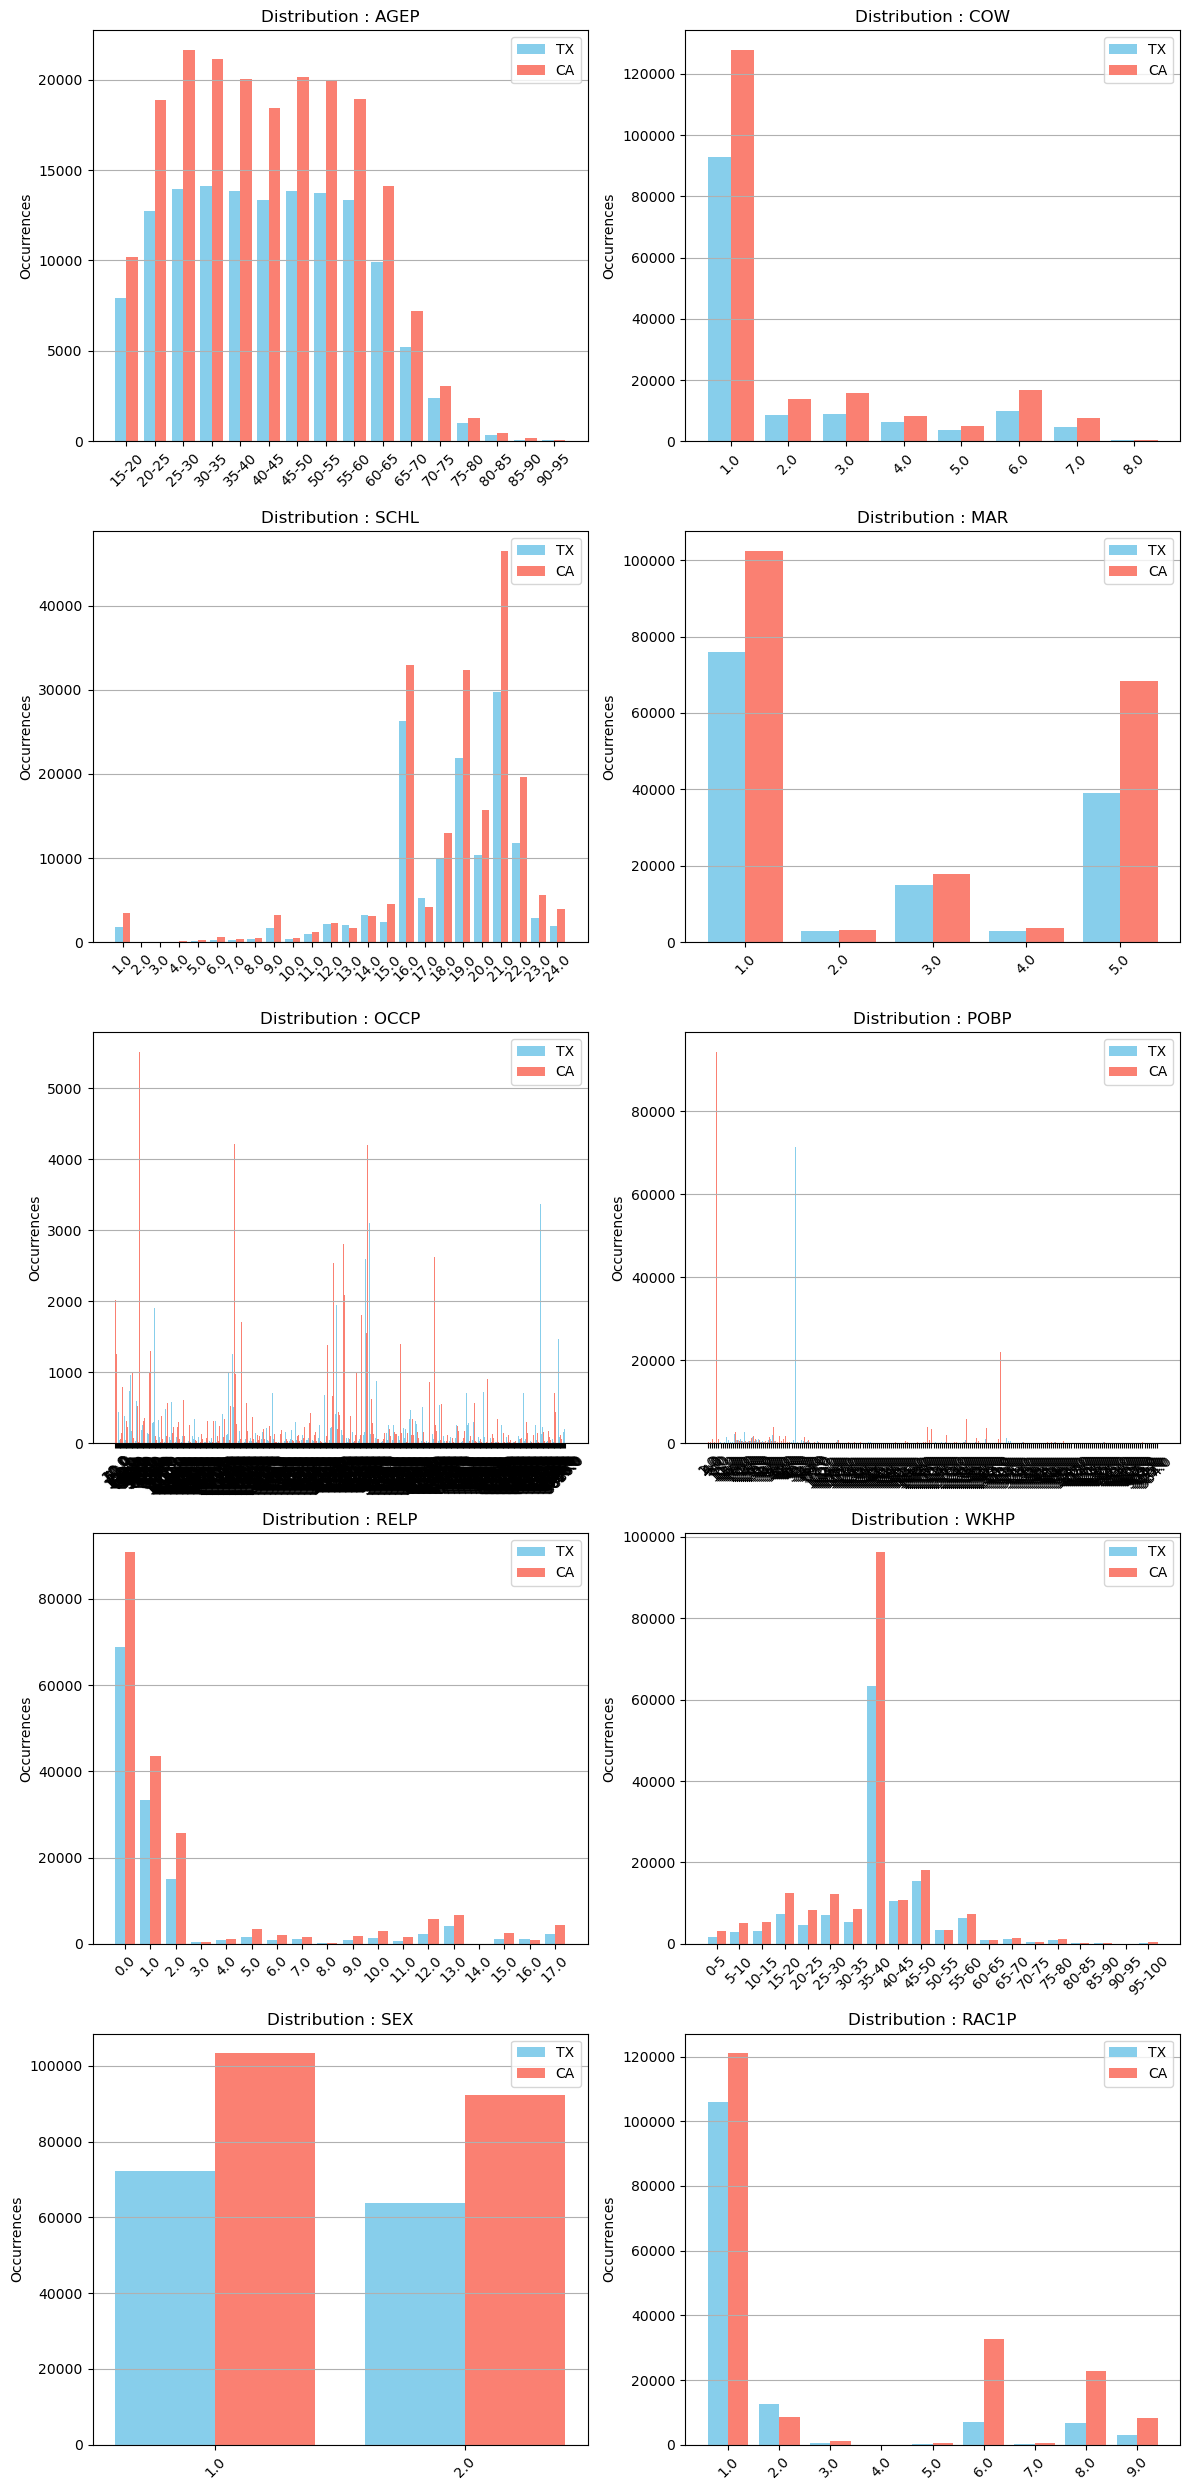

In [6]:
hist_group_nb("TX","CA")

In [7]:
features_tx["POBP"].value_counts(normalize=True)

POBP
48.0     0.525794
303.0    0.092051
6.0      0.035226
22.0     0.020004
17.0     0.015950
           ...   
423.0    0.000007
151.0    0.000007
219.0    0.000007
228.0    0.000007
508.0    0.000007
Name: proportion, Length: 219, dtype: float64

In [8]:
features_ca["POBP"].value_counts(normalize=True)

POBP
6.0      0.482713
303.0    0.111737
233.0    0.029755
207.0    0.019968
36.0     0.019590
           ...   
118.0    0.000010
321.0    0.000010
412.0    0.000005
339.0    0.000005
338.0    0.000005
Name: proportion, Length: 219, dtype: float64

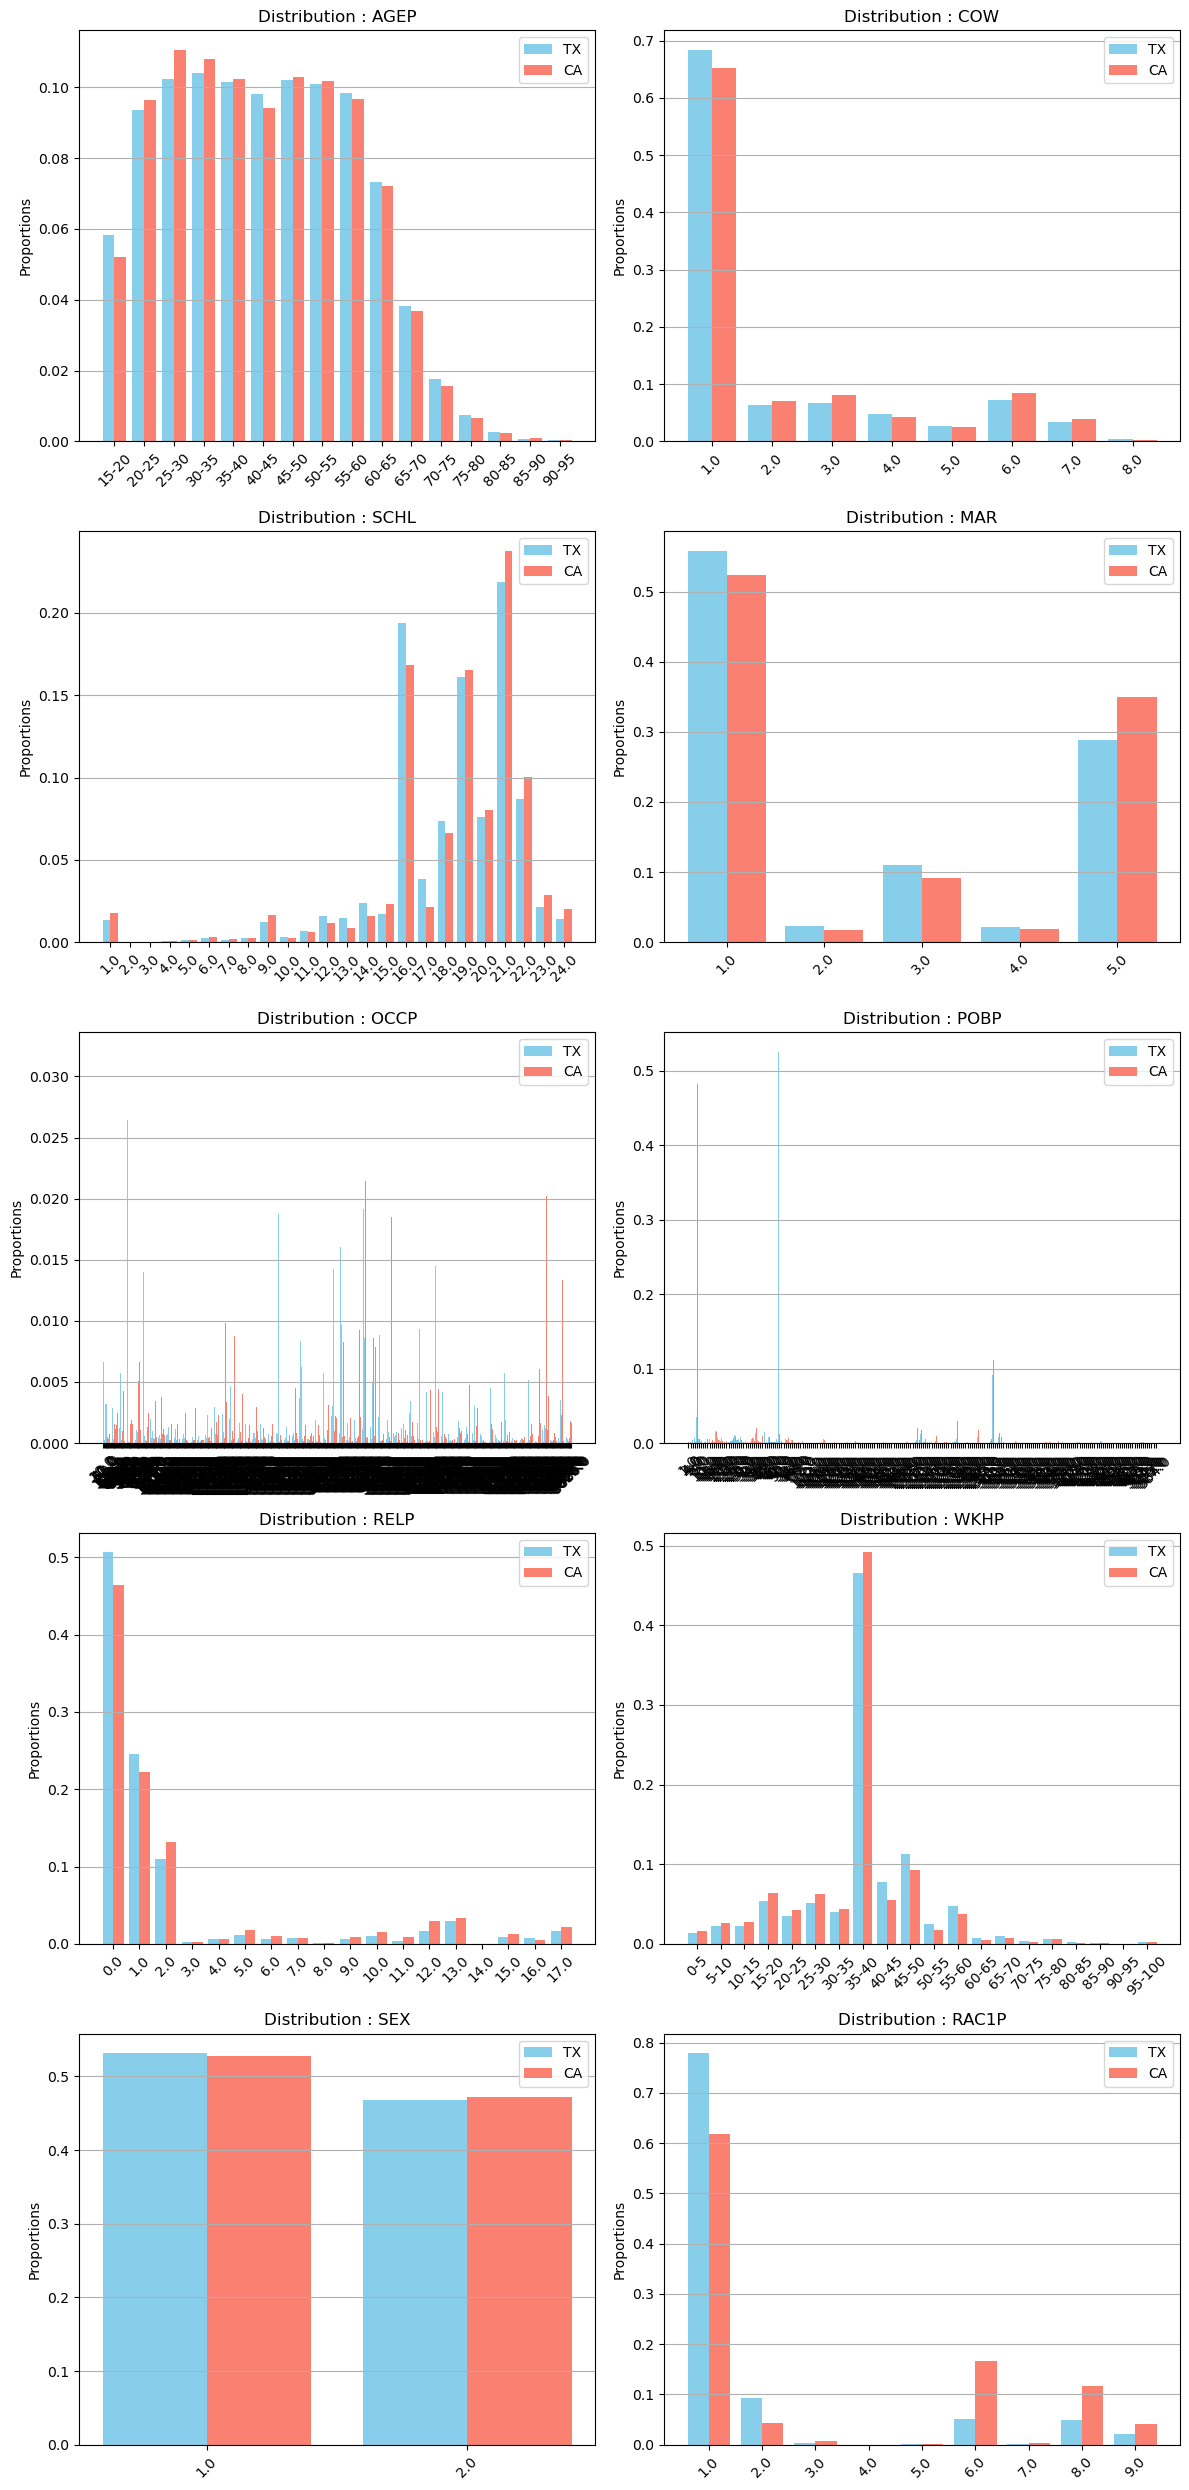

In [9]:
hist_group_prop("TX","CA")

In [10]:
from math import sqrt

def phi(cm):
    n = len(str(np.max(cm)))
    cm_00 = cm[0,0]/10**n
    cm_01 = cm[0,1]/10**n
    cm_10 = cm[1,0]/10**n
    cm_11 = cm[1,1]/10**n
    return (cm_00*cm_11-cm_01*cm_10)/(sqrt((cm_00+cm_01)*(cm_01+cm_11)*(cm_11+cm_10)*(cm_10+cm_00)))

In [11]:
from bias_measure_fcts import Cpt_DI,Cpt_EoO,Cpt_Suf

def comp_CM_per_state(state_data,state_model,model,model_name=""):
    features = globals()[f"features_{str(state_data)}"]
    label = globals()[f"label_{str(state_data)}"]

    features_model = globals()[f"features_{str(state_model)}"]
    label_model = globals()[f"label_{str(state_model)}"]

    X_train, X_test, Y_train, Y_test = train_test_split(features_model,label_model,train_size=0.7)


    if model_name == "NN":
        model.fit(X_train.values,Y_train.values.ravel(),epochs_nb=100,batch_size=300,optimizer='SGD')
    elif model_name == "Skrub":
        model.fit(X_train, Y_train)
    else:
        model.fit(X_train.values,Y_train.values.ravel())

    if state_data == state_model:   #Si les 2 Etats sont identiques, on fait la CM uniquement sur les données de test
                                    #pour ne pas biaiser avec la proportion en données d'entraînement mieux entraînée
        Y_test_pred = model.predict(X_test)
        print("Données :",state_data.upper(),"// Modèle fait sur :",state_model.upper())
        print(phi(confusion_matrix(Y_test,Y_test_pred)))
        print(confusion_matrix(Y_test,Y_test_pred),"\n")

        print("       - Accuracy =",accuracy_score(Y_test,Y_test_pred,normalize=True))
        print("       - Balanced accuracy score =",balanced_accuracy_score(Y_test,Y_test_pred))
        print("       - Disparate Impact =",Cpt_DI(2-X_test["SEX"].values,Y_test_pred.ravel()))
        print("       - Equality of Odds =",Cpt_EoO(2-X_test["SEX"].values,Y_test_pred.ravel(),Y_test.values.ravel()))
        print("       - Sufficiency =",Cpt_Suf(2-X_test["SEX"].values,Y_test_pred.ravel(),Y_test.values.ravel()),"\n")

    else:
        Y_test_pred = model.predict(features)
        
        print("Données :",state_data.upper(),"// Modèle fait sur :",state_model.upper())
        print(phi(confusion_matrix(label,model.predict(features))))
        print(confusion_matrix(label,model.predict(features)),"\n")

        print("       - Accuracy =",accuracy_score(label,Y_test_pred,normalize=True))
        print("       - Balanced accuracy score =",balanced_accuracy_score(label,Y_test_pred))
        print("       - Disparate Impact =",Cpt_DI(2-features["SEX"].values,Y_test_pred.ravel()))
        print("       - Equality of Odds =",Cpt_EoO(2-features["SEX"].values,Y_test_pred.ravel(),label.values.ravel()))
        print("       - Sufficiency =",Cpt_Suf(2-features["SEX"].values,Y_test_pred.ravel(),label.values.ravel()),"\n")

### Logistic Regression

In [12]:
model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',max_iter=10000))


comp_CM_per_state("ca","ca",model)

comp_CM_per_state("tx","ca",model)

comp_CM_per_state("tx","tx",model)

comp_CM_per_state("ca","tx",model)

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données : CA // Modèle fait sur : CA
0.5498458679882177
[[28744  5821]
 [ 6899 17236]] 

       - Accuracy = 0.783304940374787
       - Balanced accuracy score = 0.7728711134158415
       - Disparate Impact = (0.662041160552973, [0.6480014534447773, 0.6760808676611687])
       - Equality of Odds = (0.8344642108239751, [0.8198819112814596, 0.8490465103664907])
       - Sufficiency = (0.9461500340597212, [0.9310502791485468, 0.9612497889708956]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données : TX // Modèle fait sur : CA
0.5319176450557056
[[67673 18666]
 [11870 37715]] 

       - Accuracy = 0.7753450457608664
       - Balanced accuracy score = 0.772209392393447
       - Disparate Impact = (0.6621984896703116, [0.6533330251825331, 0.6710639541580901])
       - Equality of Odds = (0.8721071318117055, [0.8623853886930304, 0.8818288749303806])
       - Sufficiency = (0.8506526415284357, [0.8396723320776398, 0.8616329509792315]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données : TX // Modèle fait sur : TX
0.519937240108924
[[22242  3707]
 [ 5190  9639]] 

       - Accuracy = 0.7818186276914022
       - Balanced accuracy score = 0.7535764862287218
       - Disparate Impact = (0.4649165388002711, [0.4500785678017262, 0.479754509798816])
       - Equality of Odds = (0.6791291227236151, [0.6591135554891543, 0.699144689958076])
       - Sufficiency = (0.9330154261615863, [0.9102328033688508, 0.9557980489543217]) 

Données : CA // Modèle fait sur : TX
0.5182777333073573
[[103175  12155]
 [ 32921  47414]] 

       - Accuracy = 0.7696266578079881
       - Balanced accuracy score = 0.7424051516456405
       - Disparate Impact = (0.46767392989221374, [0.46055964767427016, 0.4747882121101573])
       - Equality of Odds = (0.6183423145668668, [0.6097726737831832, 0.6269119553505504])
       - Sufficiency = (0.9913494355103283, [0.9824318782959071, 1.0002669927247496]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### XG Boosting

In [13]:
model = XGBClassifier(max_depth=6, n_estimators = 200, random_state=8)


comp_CM_per_state("ca","ca",model)

comp_CM_per_state("tx","ca",model)

comp_CM_per_state("tx","tx",model)

comp_CM_per_state("ca","tx",model)

Données : CA // Modèle fait sur : CA
0.6399051335512206
[[29529  5232]
 [ 4994 18945]] 

       - Accuracy = 0.8257921635434412
       - Balanced accuracy score = 0.8204364670102202
       - Disparate Impact = (0.7137365278873151, [0.6993789844060798, 0.7280940713685504])
       - Equality of Odds = (0.9157151655995808, [0.9030114590755894, 0.9284188721235721])
       - Sufficiency = (0.9550912885551942, [0.941814808614689, 0.9683677684956994]) 

Données : TX // Modèle fait sur : CA
0.5839670761625696
[[66867 19472]
 [ 8505 41080]] 

       - Accuracy = 0.7941717430328713
       - Balanced accuracy score = 0.8014733776463318
       - Disparate Impact = (0.6779954095998275, [0.669488663329657, 0.6865021558699981])
       - Equality of Odds = (0.9345648631605862, [0.9263436696000167, 0.9427860567211557])
       - Sufficiency = (0.8903346963724738, [0.8797419691054359, 0.9009274236395116]) 

Données : TX // Modèle fait sur : TX
0.5980226122681471
[[22406  3610]
 [ 3928 10834]] 

       - 

### Skrub

In [14]:
model=tabular_learner('classifier')

comp_CM_per_state("ca","ca",model,"Skrub")

comp_CM_per_state("tx","ca",model,"Skrub")

comp_CM_per_state("tx","tx",model,"Skrub")

comp_CM_per_state("ca","tx",model,"Skrub")

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : CA // Modèle fait sur : CA
0.6398722046288174
[[29440  5073]
 [ 5164 19023]] 

       - Accuracy = 0.8256047700170358
       - Balanced accuracy score = 0.8197543935223202
       - Disparate Impact = (0.7077051813610625, [0.6933727526638193, 0.7220376100583058])
       - Equality of Odds = (0.9130915369256686, [0.9002401705851502, 0.925942903266187])
       - Sufficiency = (0.9530951199559049, [0.9399813465721987, 0.9662088933396111]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : TX // Modèle fait sur : CA
0.5878022621010296
[[66895 19444]
 [ 8317 41268]] 

       - Accuracy = 0.7957608663664989
       - Balanced accuracy score = 0.8035312637625004
       - Disparate Impact = (0.6692217984385792, [0.6608202309330644, 0.677623365944094])
       - Equality of Odds = (0.9258716206947318, [0.9177637204061728, 0.9339795209832908])
       - Sufficiency = (0.8936167418254378, [0.8830181412706907, 0.904215342380185]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : TX // Modèle fait sur : TX
0.5997074394903403
[[22335  3484]
 [ 4044 10915]] 

       - Accuracy = 0.8153906518220609
       - Balanced accuracy score = 0.7973608439387423
       - Disparate Impact = (0.5600341207846169, [0.5438825858943661, 0.5761856556748677])
       - Equality of Odds = (0.8376256848341561, [0.8188211115216293, 0.8564302581466829])
       - Sufficiency = (0.9585018639400633, [0.9390835714111543, 0.9779201564689723]) 



/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Données : CA // Modèle fait sur : TX
0.599222177217519
[[104301  11029]
 [ 26606  53729]] 

       - Accuracy = 0.8076559425548769
       - Balanced accuracy score = 0.7865909594378189
       - Disparate Impact = (0.6161809728894011, [0.6079087606283942, 0.624453185150408])
       - Equality of Odds = (0.8150981923938062, [0.806399407434843, 0.8237969773527695])
       - Sufficiency = (0.9918422495291265, [0.9845595904181351, 0.9991249086401178]) 



### Neural Network

In [15]:
#usefull for preprocessing data, before using gems2
from tqdm import tqdm  
import torch
import torch.nn as nn

#1) define the NN classifier model
class MyNN(nn.Module):
    def __init__(self,p):
            
            super().__init__()  #p is the dimension of the inputs
            self.fc1 = nn.Linear(p, p)
            self.relu1 = nn.ReLU()
            self.dout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(p, p)
            self.relu2 = nn.ReLU()
            self.dout2 = nn.Dropout(0.05)
            self.fc3 = nn.Linear(p, p)
            self.relu3 = nn.ReLU()
            self.dout3 = nn.Dropout(0.05)
            self.fc4 = nn.Linear(p, 1)
            self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
            a1 = self.fc1(input_)
            h1 = self.relu1(a1)
            dout1 = self.dout1(h1)
            a2 = self.fc2(dout1)
            h2 = self.relu2(a2)
            dout2 = self.dout2(h2)
            a3 = self.fc3(dout2)
            h3 = self.relu3(a3)
            dout3 = self.dout3(h3)
            a4 = self.fc4(dout3)
            y = self.out_act(a4)
            return y
        
    def predict(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(1.*(pred>0.5))
    
    def predict_proba(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(pred)



class SimpleNNclassifier:
    """
    Instanciate and train a simple NN classifier using a single command line. Although Pytorch is
    used in this class, all inputs and outputs are numpy arrays.
    
    * This class is initiated and trained with the inputs:
      -> A numpy array X of input observations
      -> A numpy array y of output observations with labels
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self,p):
        self.p = p
        print('SimpleNNclassifier created')
        
    #2) init method of SimpleNNclassifier
    def fit(self,X_train,y_train,epochs_nb=1000,batch_size=300,optimizer='SGD'):
        """
        parameters:
         - epochs_nb: epochs number
         - batch_size: batch size
         - optimizer: optimizer in ['SGD','ADAM']
        """
        #2.1) instantiate and parametrize the model
        X_trainS=sk.preprocessing.scale(X_train)
        
        n=X_trainS.shape[0]
        p=X_trainS.shape[1]

        #Initialize the model
        self.model = MyNN(self.p)
        #Define loss criterion
        #criterion = nn.BCELoss()
        criterion = nn.MSELoss()
        #Define the optimizer
        if optimizer=='SGD':
            optimizer = torch.optim.SGD(self.model.parameters(),lr=0.0001)
        else:
            optimizer = torch.optim.Adam(self.model.parameters())
        
        #2.3) train the model
        
        losses_train = []
        for i in tqdm(range(epochs_nb)):
            for beg_i in range(0, n-batch_size-1, batch_size):
                X = torch.from_numpy(X_trainS[beg_i:beg_i+batch_size,:].astype(np.float32))
                y = torch.from_numpy(y_train.reshape(-1,1)[beg_i:beg_i+batch_size,:].astype(np.float32))
                
                #Precit the output for Given input
                y_pred = self.model.forward(X)
                #Compute Cross entropy loss
                loss = criterion(y_pred,y)
                #Add loss to the list
                losses_train.append(loss.item())

                ###losses_women_train.append(loss_women.item())

                ###losses_men_train.append(loss_men.item())
                #Compute gradients
                loss.backward()
                #Adjust weights
                optimizer.step()
        plt.plot(losses_train)
        plt.show()
    
    #3) Prediction
    def predict(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict(X_test_torch)
        return y_test_pred_torch.numpy()

    def predict_proba(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict_proba(X_test_torch)
        return 1.-y_test_pred_torch.numpy()  #probability to be equal to 0 actually

SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


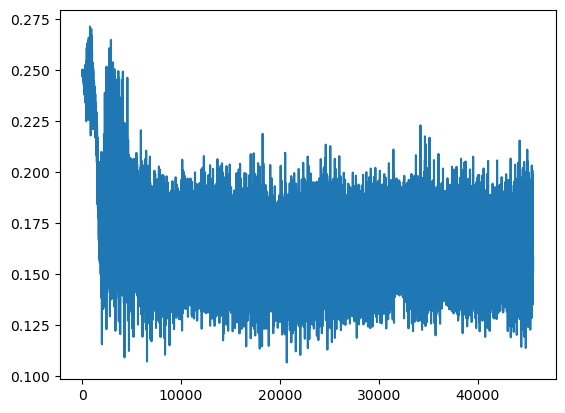

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : CA // Modèle fait sur : CA
0.5410310339660487
[[23556 10910]
 [ 3296 20938]] 

       - Accuracy = 0.7579897785349233
       - Balanced accuracy score = 0.773724448584942
       - Disparate Impact = (0.8400775945776268, [0.8273284197146018, 0.8528267694406517])
       - Equality of Odds = (0.9714415003398604, [0.9613275661518501, 0.9815554345278708])
       - Sufficiency = (0.8744506450155055, [0.8599461473312103, 0.8889551426998007]) 



100%|█████████████████████████████████████████| 100/100 [00:41<00:00,  2.44it/s]


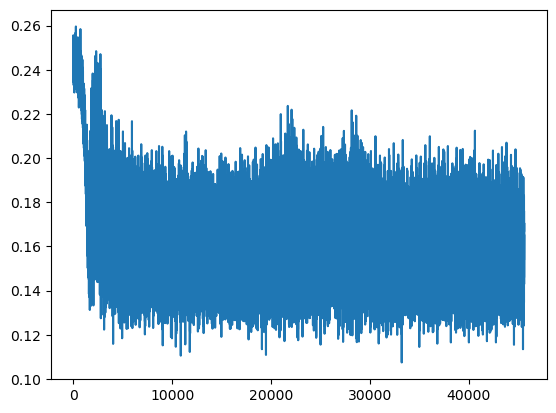

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : TX // Modèle fait sur : CA
0.5136645054867891
[[65395 20944]
 [11246 38339]] 

       - Accuracy = 0.7631029104499574
       - Balanced accuracy score = 0.7651442080866181
       - Disparate Impact = (0.6842133883648922, [0.6754838080272244, 0.69294296870256])
       - Equality of Odds = (0.8895918561656696, [0.8800888286385294, 0.8990948836928098])
       - Sufficiency = (0.8397883262481979, [0.8287450418333984, 0.8508316106629974]) 



100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


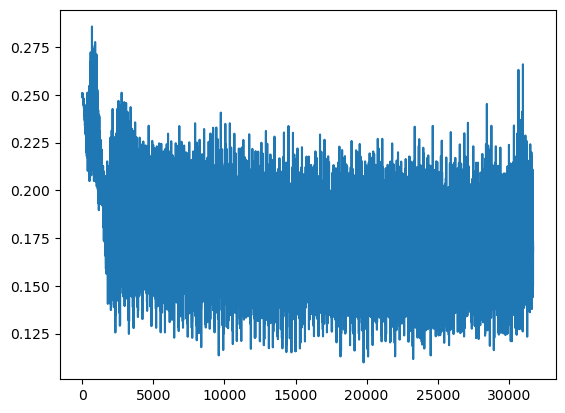

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : TX // Modèle fait sur : TX
0.5167779743350591
[[21407  4635]
 [ 4481 10255]] 

       - Accuracy = 0.7764480847515818
       - Balanced accuracy score = 0.7589665223620643
       - Disparate Impact = (0.5965906414873887, [0.5801355313859891, 0.6130457515887884])
       - Equality of Odds = (0.8058175456301127, [0.7858395703510168, 0.8257955209092085])
       - Sufficiency = (0.8519551488407264, [0.830949836107772, 0.8729604615736809]) 



100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.32it/s]


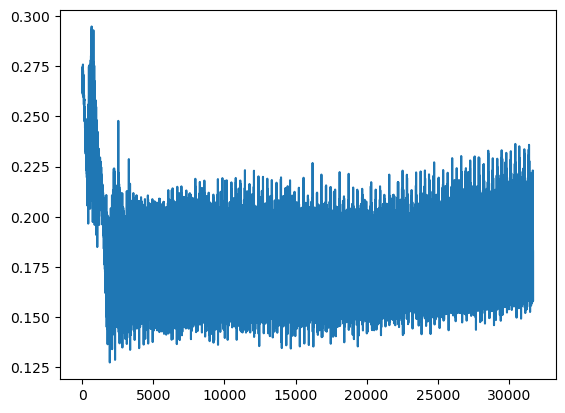

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))
/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


Données : CA // Modèle fait sur : TX
0.5054864179735846
[[82379 32951]
 [16101 64234]] 

       - Accuracy = 0.7489280147190351
       - Balanced accuracy score = 0.7566519423662654
       - Disparate Impact = (0.7932330344476902, [0.7859692722116729, 0.8004967966837075])
       - Equality of Odds = (0.9398108022611706, [0.9329619148847308, 0.9466596896376105])
       - Sufficiency = (0.8883428226754482, [0.8799385048436286, 0.8967471405072678]) 



In [16]:
model = SimpleNNclassifier(10)


comp_CM_per_state("ca","ca",model,"NN")

comp_CM_per_state("tx","ca",model,"NN")

comp_CM_per_state("tx","tx",model,"NN")

comp_CM_per_state("ca","tx",model,"NN")

In [17]:
features_tx["SEX"].value_counts(normalize=True)

SEX
1.0    0.531393
2.0    0.468607
Name: proportion, dtype: float64

### Sample en changeant la proportion de la variable SEX

In [18]:
def sample_variable(variable,target_proportions,sample_size=100000):

    #p=0.5
    #target_proportions = {
    #    '1.0' : p, #Hommes
    #    '2.0' : 1-p  #Femmes
    #}

    counts = {val: int(sample_size * prop) for val, prop in target_proportions.items()}
    counts  #valeurs que l'on veut prendre par attribut dans le sample


    features_sample = []
    label_sample = []

    for val, n in counts.items():
        df = features_tx[features_tx[variable].astype(str) == val].sample(n=n,replace=True)
        list_index = df.index.tolist()

        features_sample.append(df)

        label_sample.append(label_tx.iloc[list_index,:])
        

    features_sample = pd.concat(features_sample).sample(frac=1, random_state=0).reset_index(drop=True)
    label_sample = pd.concat(label_sample).sample(frac=1, random_state=0).reset_index(drop=True)
    return features_sample,label_sample

- ### Avec régression logistique

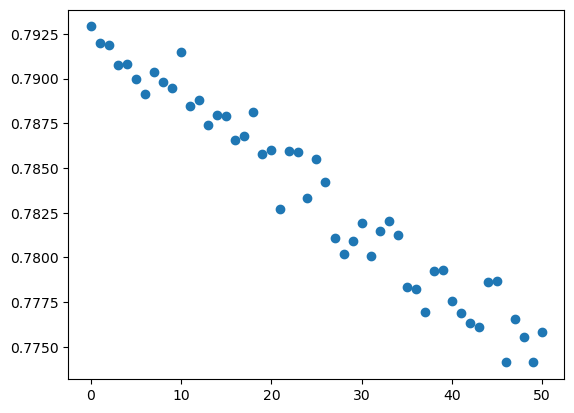

In [19]:
pred = []
nb_it = 50
for k in range(nb_it+1):
    model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',max_iter=10000))

    p=k/nb_it
    target_proportions = {
        '1.0' : p, #Hommes
        '2.0' : 1-p  #Femmes
    }
    features_sample,label_sample = sample_variable("SEX",target_proportions)

    X_train, X_test, Y_train, Y_test = train_test_split(features_tx,label_tx,train_size=0.7)

    model.fit(X_train,Y_train.values.ravel())

    Y_sample_pred = model.predict(features_sample)
    cm = confusion_matrix(label_sample,Y_sample_pred)
    #comp_CM_per_state("sample","sample",model)
    pred.append([k,(cm[0,0]+cm[1,1])/sum(sum(cm))])

plt.scatter([x[0] for x in pred],[x[1] for x in pred])

- ### Avec XGBoost

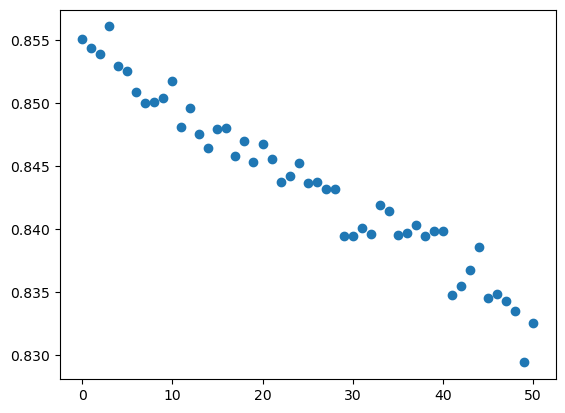

In [20]:
pred = []
nb_it = 50
for k in range(nb_it+1):
    model = XGBClassifier(max_depth=6, n_estimators = 200, random_state=8)

    p=k/nb_it
    target_proportions = {
        '1.0' : p, #Hommes
        '2.0' : 1-p  #Femmes
    }
    features_sample,label_sample = sample_variable("SEX",target_proportions)

    X_train, X_test, Y_train, Y_test = train_test_split(features_tx,label_tx,train_size=0.7)

    model.fit(X_train,Y_train)

    Y_sample_pred = model.predict(features_sample)
    cm = confusion_matrix(label_sample,Y_sample_pred)
    #comp_CM_per_state("sample","sample",model)
    pred.append([k,(cm[0,0]+cm[1,1])/sum(sum(cm))])


plt.scatter([x[0] for x in pred],[x[1] for x in pred])

- ### Avec Skrub

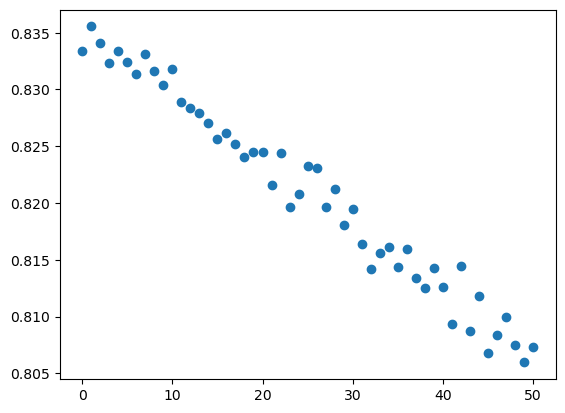

In [21]:
pred = []
nb_it = 50
for k in range(nb_it+1):
    model = tabular_learner('classifier')

    p=k/nb_it
    target_proportions = {
        '1.0' : p, #Hommes
        '2.0' : 1-p  #Femmes
    }
    features_sample,label_sample = sample_variable("SEX",target_proportions)

    X_train, X_test, Y_train, Y_test = train_test_split(features_tx,label_tx,train_size=0.7)

    model.fit(X_train,Y_train.values.ravel())

    Y_sample_pred = model.predict(features_sample)
    cm = confusion_matrix(label_sample,Y_sample_pred)
    #comp_CM_per_state("sample","sample",model)
    pred.append([k,(cm[0,0]+cm[1,1])/sum(sum(cm))])

plt.scatter([x[0] for x in pred],[x[1] for x in pred])

- ### Avec Réseau de neurones

SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


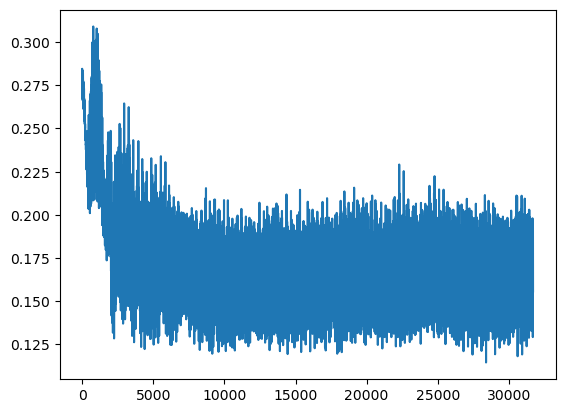

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


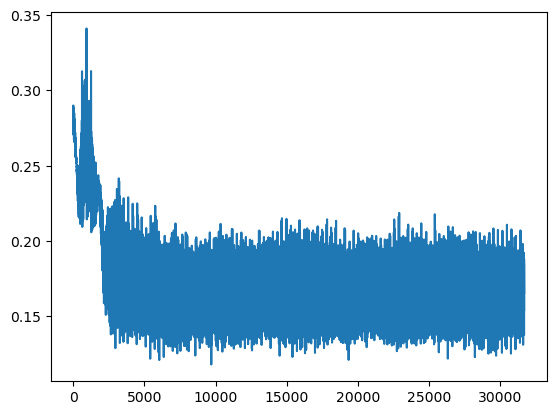

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


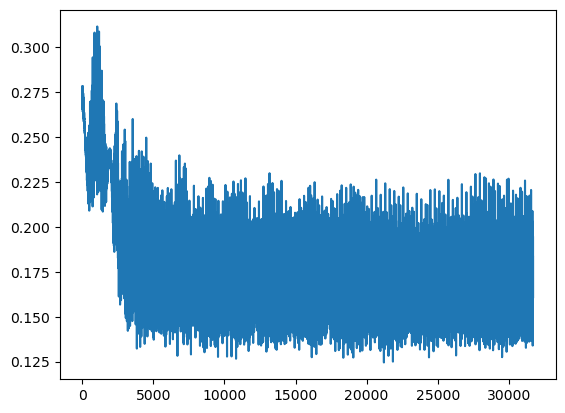

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


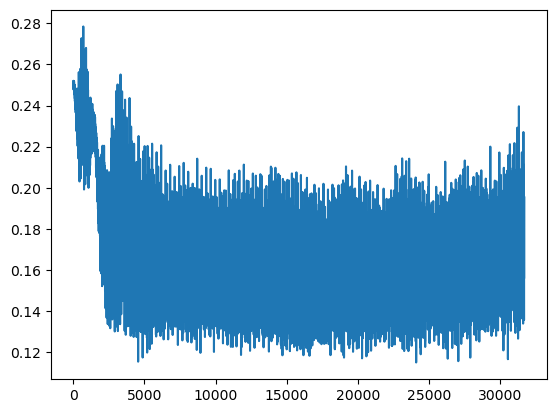

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


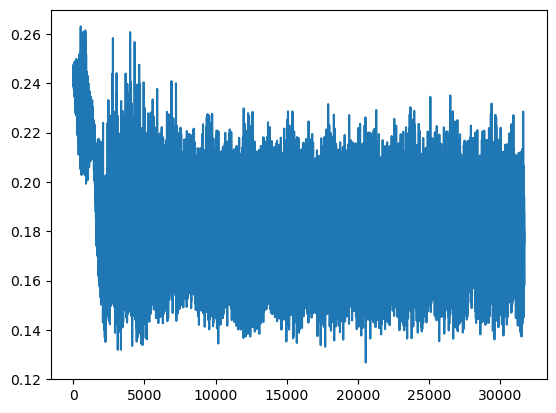

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


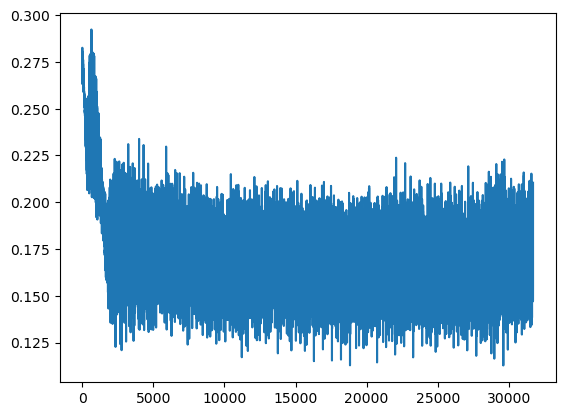

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


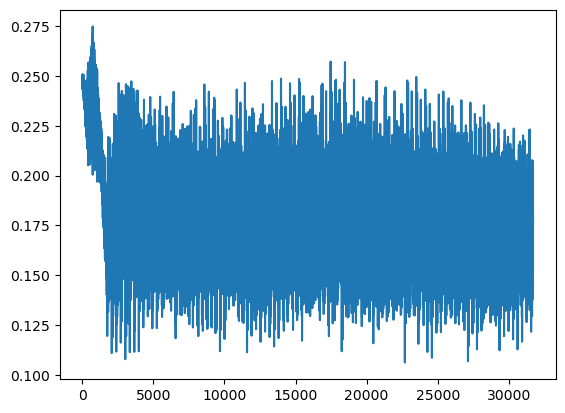

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


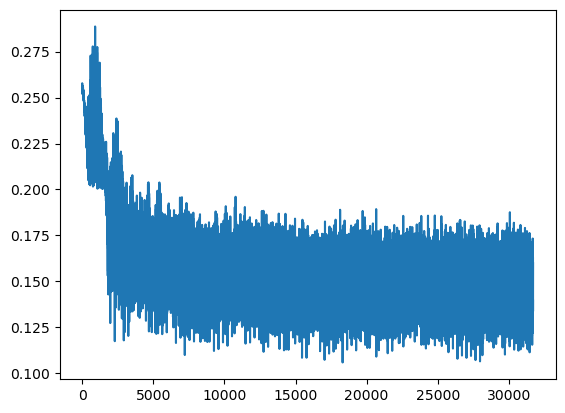

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


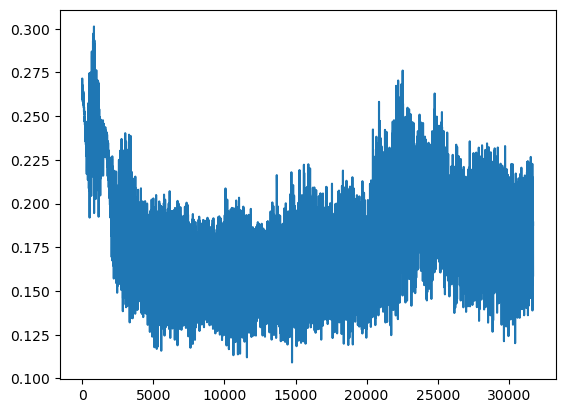

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


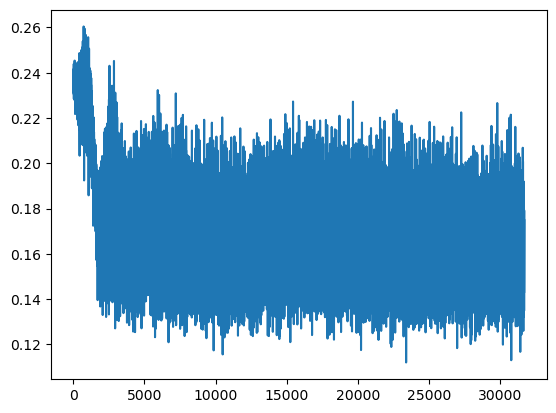

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


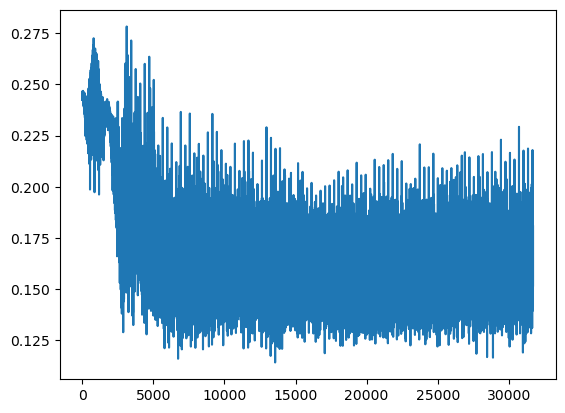

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


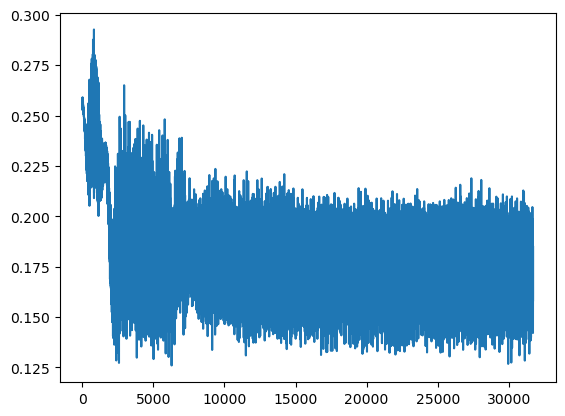

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


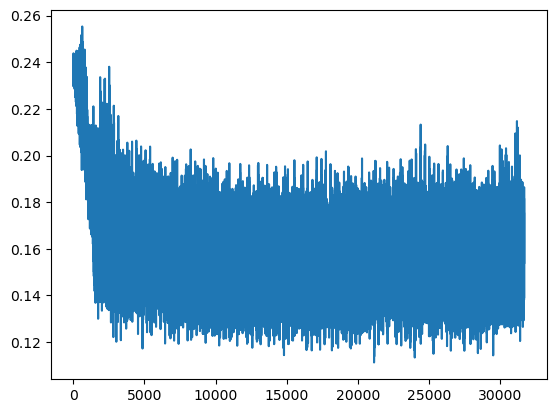

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


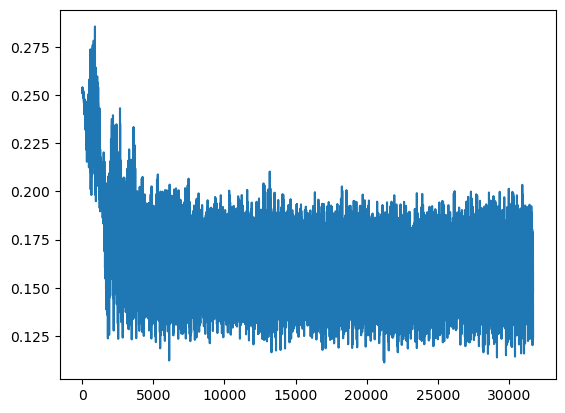

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


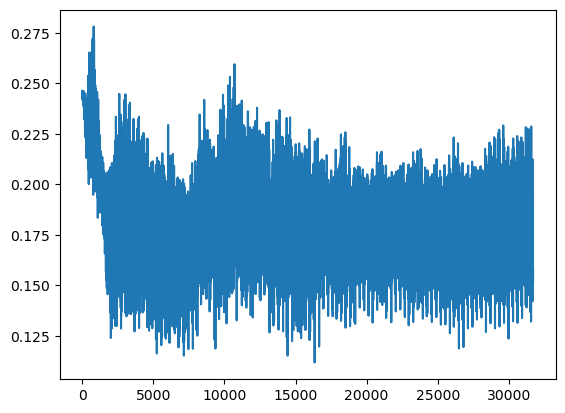

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.36it/s]


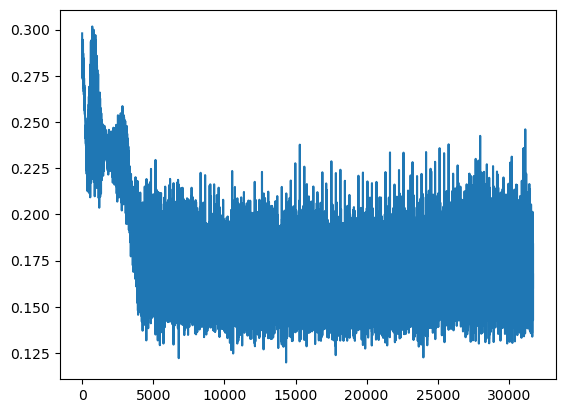

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.14it/s]


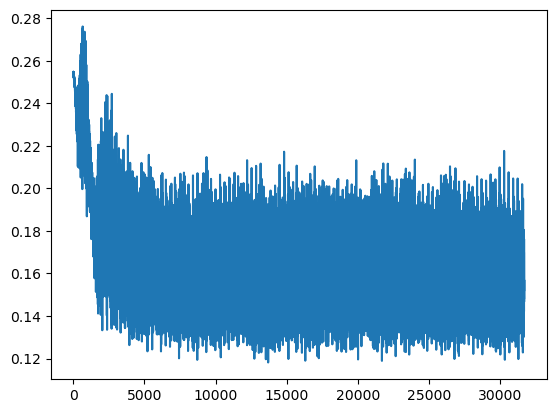

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.28it/s]


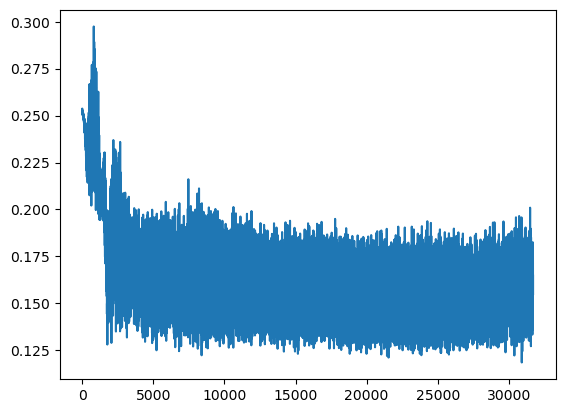

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.32it/s]


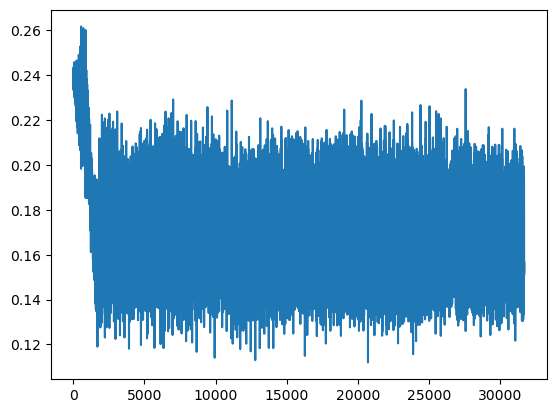

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.29it/s]


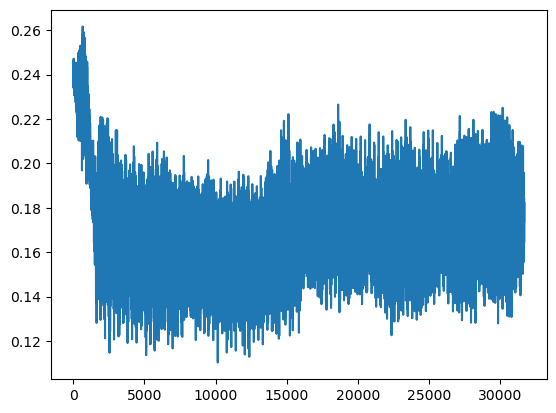

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


SimpleNNclassifier created


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


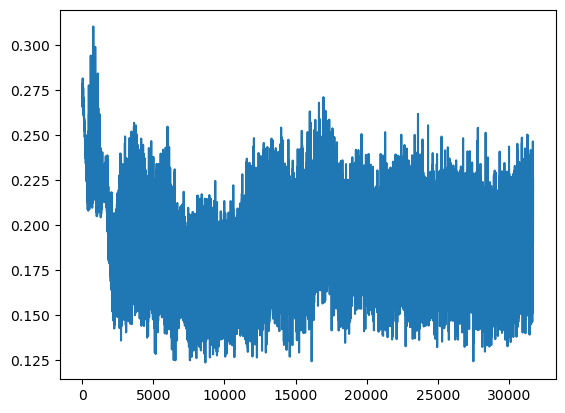

/tmp/ipykernel_6244/3409401895.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1.*(pred>0.5))


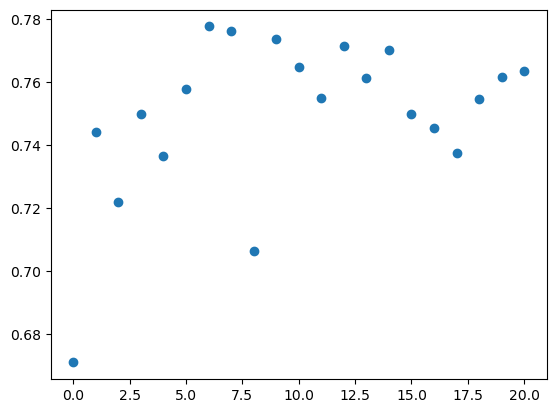

In [22]:
pred = []
nb_it = 20
for k in range(nb_it+1):
    model = SimpleNNclassifier(10)

    p=k/nb_it
    target_proportions = {
        '1.0' : p, #Hommes
        '2.0' : 1-p  #Femmes
    }
    features_sample,label_sample = sample_variable("SEX",target_proportions)

    X_train, X_test, Y_train, Y_test = train_test_split(features_tx,label_tx,train_size=0.7)

    model.fit(X_train.values,Y_train.values.ravel(),epochs_nb=100,batch_size=300,optimizer='SGD')

    Y_sample_pred = model.predict(features_sample)
    cm = confusion_matrix(label_sample,Y_sample_pred)
    #comp_CM_per_state("sample","sample",model)
    pred.append([k,(cm[0,0]+cm[1,1])/sum(sum(cm))])

plt.scatter([x[0] for x in pred],[x[1] for x in pred])

### Sample en changeant variable COW

In [23]:
pred = []
for k in range(100):
    model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',max_iter=10000))

    p=np.random.dirichlet([1 for _ in range(8)])
    target_proportions = {
        '1.0' : p[0],
        '2.0' : p[1],
        '3.0' : p[2],
        '4.0' : p[3],
        '5.0' : p[4],
        '6.0' : p[5],
        '7.0' : p[6],
        '8.0' : p[7]
    }
    features_sample,label_sample = sample_variable("COW",target_proportions)

    X_train, X_test, Y_train, Y_test = train_test_split(features_tx,label_tx,train_size=0.7)

    model.fit(X_train,Y_train)

    Y_sample_pred = model.predict(features_sample)
    cm = confusion_matrix(label_sample,Y_sample_pred)
    #comp_CM_per_state("sample","sample",model)
    pred.append([k,(cm[0,0]+cm[1,1])/sum(sum(cm))])

/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/luana/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

### Performance en fonction de la répartition de COW

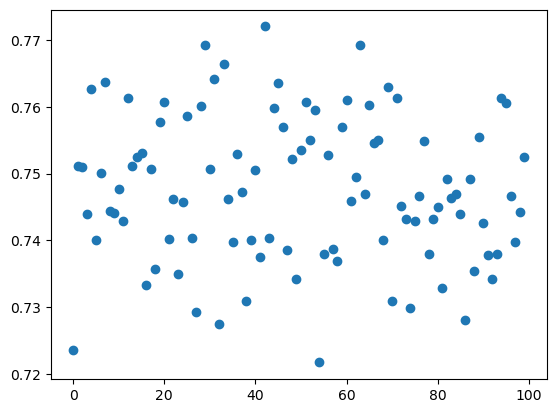

In [24]:
plt.scatter([x[0] for x in pred],[x[1] for x in pred])

In [25]:
np.random.dirichlet([1 for _ in range(3)],10)

array([[0.02229507, 0.67920995, 0.29849498],
       [0.41571872, 0.55430598, 0.0299753 ],
       [0.22382165, 0.42625767, 0.34992068],
       [0.42499011, 0.32469653, 0.25031336],
       [0.65071116, 0.23164285, 0.11764599],
       [0.19423618, 0.36334242, 0.4424214 ],
       [0.24440339, 0.60198461, 0.153612  ],
       [0.20781669, 0.16638352, 0.62579979],
       [0.04259601, 0.87852183, 0.07888217],
       [0.0782444 , 0.35343549, 0.56832011]])

## Accuracy par modèle

/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:93: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  DI_Ref=cptDI(S_test.ravel(),y_test.ravel())
/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:101: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  DI_clf=cptDI(S_test.ravel(),y_test_pred.ravel())
/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:110: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  lst_tpr_S0[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)*(S_test.ravel()==0)) / np.sum((y_test_pred.ravel()==1)*(S_test.ravel()==0)) )
/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:111: Fut

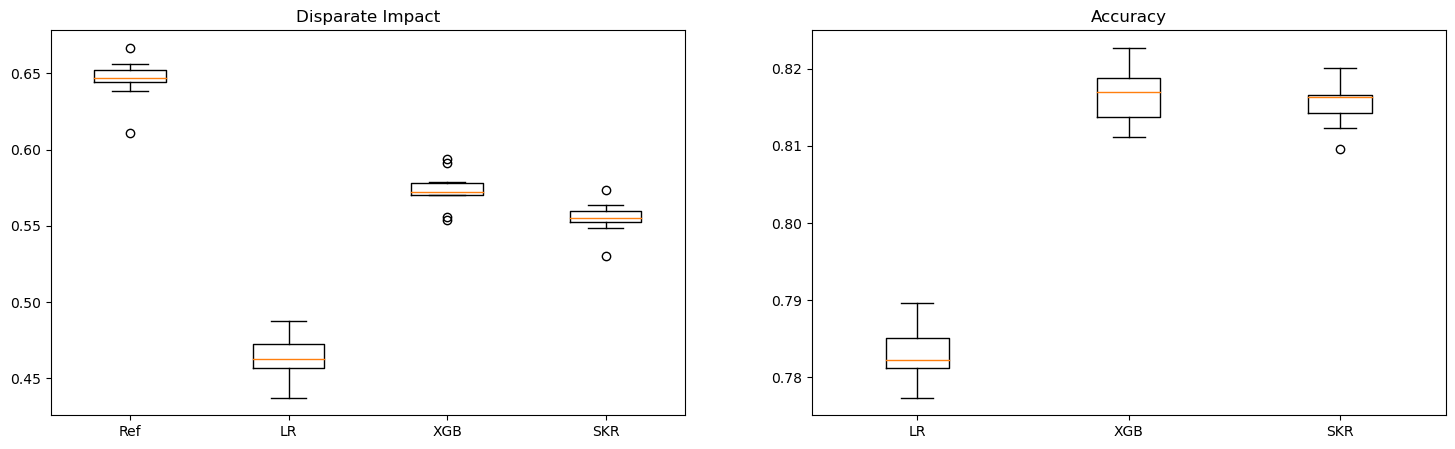

/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:186: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(lst_tnr[i], lst_tpr[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:199: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(lst_tnr_S0[i], lst_tpr_S0[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
/home/luana/Bureau/finances/FinalBiasAnalysis_compBWAF.py:212: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in fa

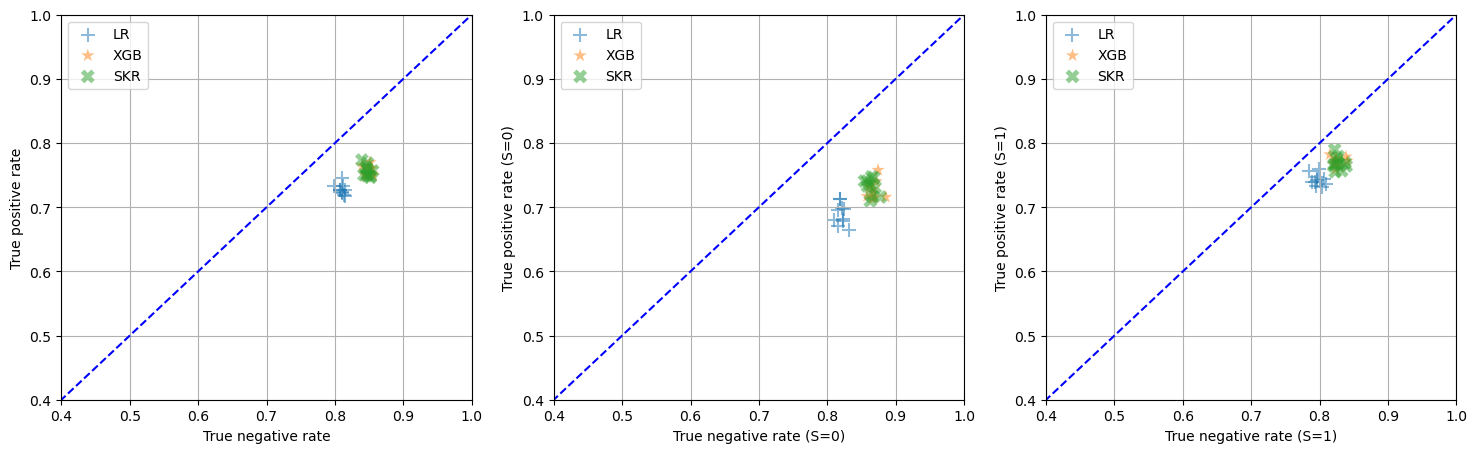

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.69 0.74
 -> True negative (all/S=0/S=1): 0.81 0.82 0.8
Average rates XGB:
 -> True positive (all/S=0/S=1): 0.76 0.73 0.77
 -> True negative (all/S=0/S=1): 0.85 0.87 0.83
Average rates SKR:
 -> True positive (all/S=0/S=1): 0.76 0.73 0.77
 -> True negative (all/S=0/S=1): 0.85 0.86 0.83


In [26]:
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+            SENSITIVE VARIABLE = Sex            +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
from FinalBiasAnalysis_compBWAF import Make_Kfold_boxplots


S=2-features_tx["SEX"]

model_LR = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs',max_iter=10000))


model_XGB = XGBClassifier(max_depth=6, n_estimators = 200, random_state=8)
model_SKR = tabular_learner('classifier')

#model_NN= SimpleNNclassifier(10)


list_classifiers=[model_LR,model_XGB,model_SKR]
list_classifierNames=['LR','XGB','SKR']

#list_classifiers=[model_LR,model_XGB,model_SKR,model_NN]
#list_classifierNames=['LR','XGB','SKR','NN']

nsplits=10


X_scaled=sk.preprocessing.scale(features_tx)

PreFigNam='StandardSex'
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,label_tx.values,nsplits,printAverageRes=False,PrefixFigNames=PreFigNam)